[![Fixel Algorithms](https://i.imgur.com/AqKHVZ0.png)](https://fixelalgorithms.gitlab.io/)

# Polynomial Regression

> Notebook by:
> - Royi Avital RoyiAvital@fixelalgorithms.com

## Revision History

| Version | Date       | User        |Content / Changes                                                   |
|---------|------------|-------------|--------------------------------------------------------------------|
| 1.0.000 | 07/04/2024 | Royi Avital | First version                                                      |

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/AIProgram/2024_02/0052RegressorLocalPolynomial.ipynb)

In [1]:
# Import Packages

# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

# Miscellaneous
import math
import os
from platform import python_version
import random
import timeit

# Typing
from typing import Callable, Dict, List, Optional, Self, Set, Tuple, Union

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter
from IPython import get_ipython
from IPython.display import Image
from IPython.display import display
from ipywidgets import Dropdown, FloatSlider, interact, IntSlider, Layout, SelectionSlider
from ipywidgets import interact

## Notations

* <font color='red'>(**?**)</font> Question to answer interactively.
* <font color='blue'>(**!**)</font> Simple task to add code for the notebook.
* <font color='green'>(**@**)</font> Optional / Extra self practice.
* <font color='brown'>(**#**)</font> Note / Useful resource / Food for thought.

Code Notations:

```python
someVar    = 2; #<! Notation for a variable
vVector    = np.random.rand(4) #<! Notation for 1D array
mMatrix    = np.random.rand(4, 3) #<! Notation for 2D array
tTensor    = np.random.rand(4, 3, 2, 3) #<! Notation for nD array (Tensor)
tuTuple    = (1, 2, 3) #<! Notation for a tuple
lList      = [1, 2, 3] #<! Notation for a list
dDict      = {1: 3, 2: 2, 3: 1} #<! Notation for a dictionary
oObj       = MyClass() #<! Notation for an object
dfData     = pd.DataFrame() #<! Notation for a data frame
dsData     = pd.Series() #<! Notation for a series
hObj       = plt.Axes() #<! Notation for an object / handler / function handler
```

### Code Exercise

 - Single line fill

 ```python
 vallToFill = ???
 ```

 - Multi Line to Fill (At least one)

 ```python
 # You need to start writing
 ????
 ```

 - Section to Fill

```python
#===========================Fill This===========================#
# 1. Explanation about what to do.
# !! Remarks to follow / take under consideration.
mX = ???

???
#===============================================================#
```

In [2]:
# Configuration
# %matplotlib inline

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

# Matplotlib default color palette
lMatPltLibclr = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# sns.set_theme() #>! Apply SeaBorn theme

runInGoogleColab = 'google.colab' in str(get_ipython())


In [3]:
# Constants

FIG_SIZE_DEF    = (8, 8)
ELM_SIZE_DEF    = 50
CLASS_COLOR     = ('b', 'r')
EDGE_COLOR      = 'k'
MARKER_SIZE_DEF = 10
LINE_WIDTH_DEF  = 2


In [4]:
# Courses Packages
import sys
sys.path.append('../')
sys.path.append('../../')
sys.path.append('../../../')
from utils.DataVisualization import PlotRegressionData


In [ ]:
# General Auxiliary Functions



## Local Polynomial Regression

Conceptually similar to _Kernel Regression_.  
It extend the _Kernel Regression_ by:

1. Applying a feature transform on the data (Polynomial).
2. Find the optimal local parameters of the polynomial.

* <font color='brown'>(**#**)</font> Common related model is the Spline Model. Splines limits the window of neighbors.
* <font color='brown'>(**#**)</font> Relevant SciKit Learn classes are: [`KNeighborsRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html), [`RadiusNeighborsRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.RadiusNeighborsRegressor.html).
* <font color='brown'>(**#**)</font> Exact implementation is given in [`LOCALREG`](https://github.com/sigvaldm/localreg) Python package.


In [5]:
# Parameters

# Data Generation
numSamples  = 200
noiseStd    = 0.01

# Data Visualization
gridNoiseStd = 0.05
numGridPts   = 500


## Generate / Load Data

In the following we'll generate data according to the following model:

$$ y_{i} = f \left( x_{i} \right) + \epsilon_{i} $$

Where

$$ f \left( x \right) = 5 \exp \left( - x \right) \sin \left( 10 x + 0.5 \right) + \left( 1 + 10 \mathcal{I}_{x > 2} \left( x - 2 \right) \right) + 1 $$


In [6]:
# Data Generating Function
def f( vX: np.ndarray ) -> np.ndarray:
    
    return 5 * np.exp(-vX) * np.sin(10 * vX + 0.5) * (1 + 10 * (vX > 2) * (vX - 2)) + 1

In [7]:
# Generate Data

vX = 4 * np.sort(np.random.rand(numSamples))
vY = f(vX) + (noiseStd * np.random.randn(numSamples))

print(f'The features data shape: {vX.shape}')
print(f'The labels data shape: {vY.shape}')

The features data shape: (200,)
The labels data shape: (200,)


### Plot Data

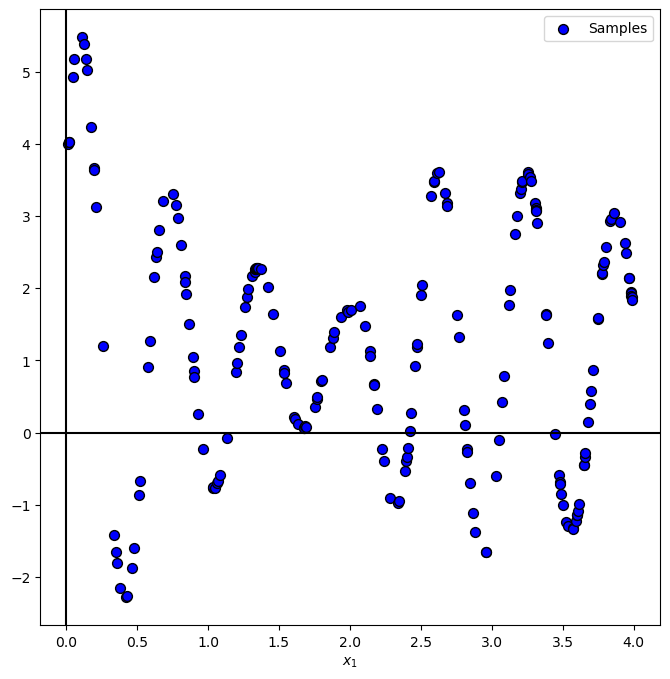

In [8]:
# Plot the Data

PlotRegressionData(vX, vY)

plt.show()


## Local Polynomial Regression

$$\boldsymbol{p}^{\star}=\arg\min_{\boldsymbol{p}\in\mathbb{R}^{P+1}}\sum_{i=1}^{N}w_{i}\left(y_{i}-\boldsymbol{\phi}^{T}\left(x_{i}-x_{0}\right)\boldsymbol{p}\right)^{2}$$

With the weighing:

$$w_{i}=k\left(\left\Vert \frac{1}{h}\left(\boldsymbol{x}_{0}-\boldsymbol{x}_{i}\right)\right\Vert _{2}\right)$$

For Gaussian Kernel weighing:

$$k\left(u\right)=e^{-\frac{1}{2}u^{2}}$$



In [9]:
# The Regressor Function

# Gaussian Kernel
def KernelGaussian( vU: np.ndarray ):
    return np.exp(-0.5 * np.square(vU))

# Estimate f(x₀)
def LocalPolynomialRegression( mX: np.ndarray, mG: np.ndarray, vY: np.ndarray, paramH: float, polyDeg: int = 2 ):
    # `mG`: Grid where `vY` is evaluated.
    # `mX`: Grid to be estimated.
    
    # Compute u = ||H^-1 (x₀ - x_i)||
    mD = sp.spatial.distance.cdist(mX, mG, metric = 'mahalanobis') #<! vU.shape = (1, N)
    # vU = vU.squeeze() #<! vU.shape = (N,)

    # Compute weights around x₀:
    mW  = KernelGaussian(mD / paramH)

    numPts = mX.shape[0]
    vYPred = np.zeros(numPts)

    
    # PolyFit with x_0 subtraction
    oPolyFit = Pipeline([
        ('PolyFeatures', PolynomialFeatures(degree = polyDeg, include_bias = False)),
        ('LinearRegression', LinearRegression(fit_intercept = True))
    ])
    
    for ii in range(numPts):
        # Fit the model (Optimal weights)
        vW = mW[ii]
        oPolyFit.fit(mG - mX[ii], vY, **{'LinearRegression__sample_weight': vW})
        # Predict the value (Basically around 0)
        vYPred[ii] = oPolyFit.predict(np.atleast_2d(0.0)).item(0) #<! Scalar!

    return vYPred

* <font color='brown'>(**#**)</font> In practice, in order to be able to use high degree polynomial one must apply some regularization.

In [10]:
# Applying and Plotting the Kernels

vG = np.linspace(-0.05, 4.05, 1000, endpoint = True)

def PlotLocalPolyRegression( paramH: float, polyDeg: int, vX: np.ndarray, vG: np.ndarray, vY: np.ndarray, figSize = FIG_SIZE_DEF, hA = None ):

    if hA is None:
        hF, hA = plt.subplots(figsize = figSize)
    else:
        hF = hA.get_figure()
    
    vYPred = LocalPolynomialRegression(np.reshape(vX, (-1, 1)), np.reshape(vG, (-1, 1)), vY, paramH = paramH, polyDeg = polyDeg)
    
    hA.plot(vX, vYPred, 'b', lw = 2, label = '$\hat{f}(x)$')
    hA.scatter(vG, vY, s = 50, c = 'r', edgecolor = 'k', label = '$y_i = f(x_i) + \epsilon_i$')
    hA.set_title(f'Local Polynomial Regression with h = {paramH}, p = {polyDeg}')
    hA.set_xlabel('$x$')
    hA.set_ylabel('$y$')
    hA.grid()
    hA.legend(loc = 'lower right')

In [11]:
hPlotLocalPolyRegression = lambda paramH, polyDeg: PlotLocalPolyRegression(paramH, polyDeg, vG, vX, vY)

hSlider = FloatSlider(min = 0.001, max = 0.5, step = 0.001, value = 0.01, readout_format = '0.3f', layout = Layout(width = '30%'))
pSlider = IntSlider(min = 1, max = 5, step = 1, value = 2, layout = Layout(width = '30%'))
interact(hPlotLocalPolyRegression, paramH = hSlider, polyDeg = pSlider)
plt.show()

interactive(children=(FloatSlider(value=0.01, description='paramH', layout=Layout(width='30%'), max=0.5, min=0…

* <font color='blue'>(**!**)</font> Play with the number of samples of the data to see its effect.
* <font color='red'>(**?**)</font> What happens outside of the data samples? What does it mean for real world data?